In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project
from CMap2D import CMap2D, gridshow
import imageio as Image

### Poses got from map -> camera_link, when in mapping mode (localization is False)

In [97]:
path_input = "../Results/Poses_Results/TF_no_localization/map_camera.txt"
path_output = "../Results/Poses_Results/TF_no_localization/map_camera_parsed.txt"

In [98]:
project.parse_pose_from_TF(path_input, path_output)

In [99]:
poses_TF_mapping = pd.read_csv(path_output)

In [100]:
poses_TF_mapping.head(5)

,Time,X,Y,Z,Roll,Pitch,Yaw
0,8603.967,0.890,-1.286,0.235,-0.0,-0.0,-2.156
1,8604.967,0.890,-1.286,0.235,-0.0,-0.0,-2.156
2,8605.968,0.890,-1.286,0.235,0.0,0.0,-2.156
3,8606.967,0.891,-1.286,0.235,-0.0,0.0,-2.156
4,8607.967,0.891,-1.286,0.235,-0.0,0.0,-2.156


In [101]:
poses_TF_mapping.shape

(195, 7)

### Poses got from map -> camera_link, when in localization mode (localization is True)

In [102]:
path_input = "../Results/Poses_Results/TF_with_localization/map_camera.txt"
path_output = "../Results/Poses_Results/TF_with_localization/map_camera_parsed.txt"

In [103]:
project.parse_pose_from_TF(path_input, path_output)

In [104]:
poses_TF_localization = pd.read_csv(path_output)

In [105]:
poses_TF_localization.head(5)

,Time,X,Y,Z,Roll,Pitch,Yaw
0,8603.967,0.89,-1.286,0.235,-0.0,-0.0,-2.156
1,8604.967,0.89,-1.286,0.235,-0.0,-0.0,-2.156
2,8605.968,0.89,-1.286,0.235,0.0,0.0,-2.157
3,8606.967,0.89,-1.287,0.235,-0.0,0.0,-2.156
4,8607.967,0.89,-1.288,0.235,-0.0,0.0,-2.156


In [106]:
poses_TF_localization.shape

(195, 7)

### Data from camera_info topic (no need to parse, it is always the same)

In [107]:
D = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
K = np.array([554.3827128226441, 0.0, 320.5, 0.0, 554.3827128226441, 240.5, 0.0, 0.0, 1.0])

# Projection

### Trajectory

Loading map definition from ../Results/Map/rtabmap.yaml
Map definition found. Loading map from ../Results/Map/rtabmap.pgm
(195, 2)


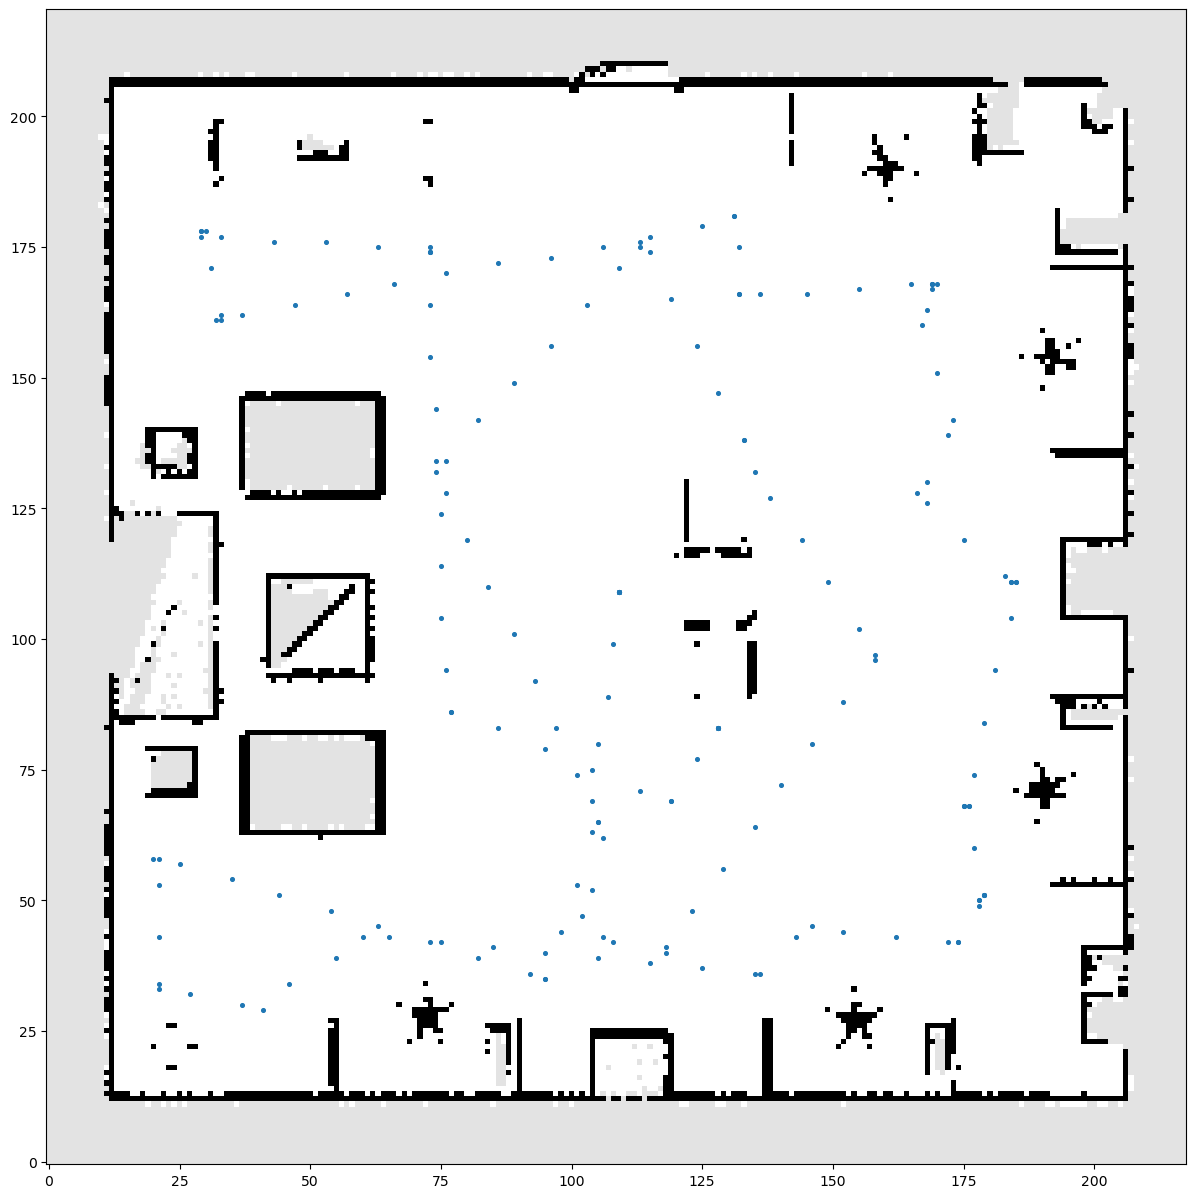

In [108]:
map = CMap2D("../Results/Map", "rtabmap")
occ_grid = map.occupancy()
origin = map.origin_xy()
x = poses_TF_localization['X']
y = poses_TF_localization['Y']
positions = np.zeros((x.shape[0],2))
print(positions.shape)
positions[:,0] = x
positions[:,1] = y
ij_positions = map.xy_to_ij(positions)
plt.figure(figsize=(15,15))
gridshow(occ_grid, cmap='Greys')
plt.scatter(ij_positions[:,0], ij_positions[:,1], s=7, )

# occ_grid[ij_positions[:,0], ij_positions[:,1]]

### init position

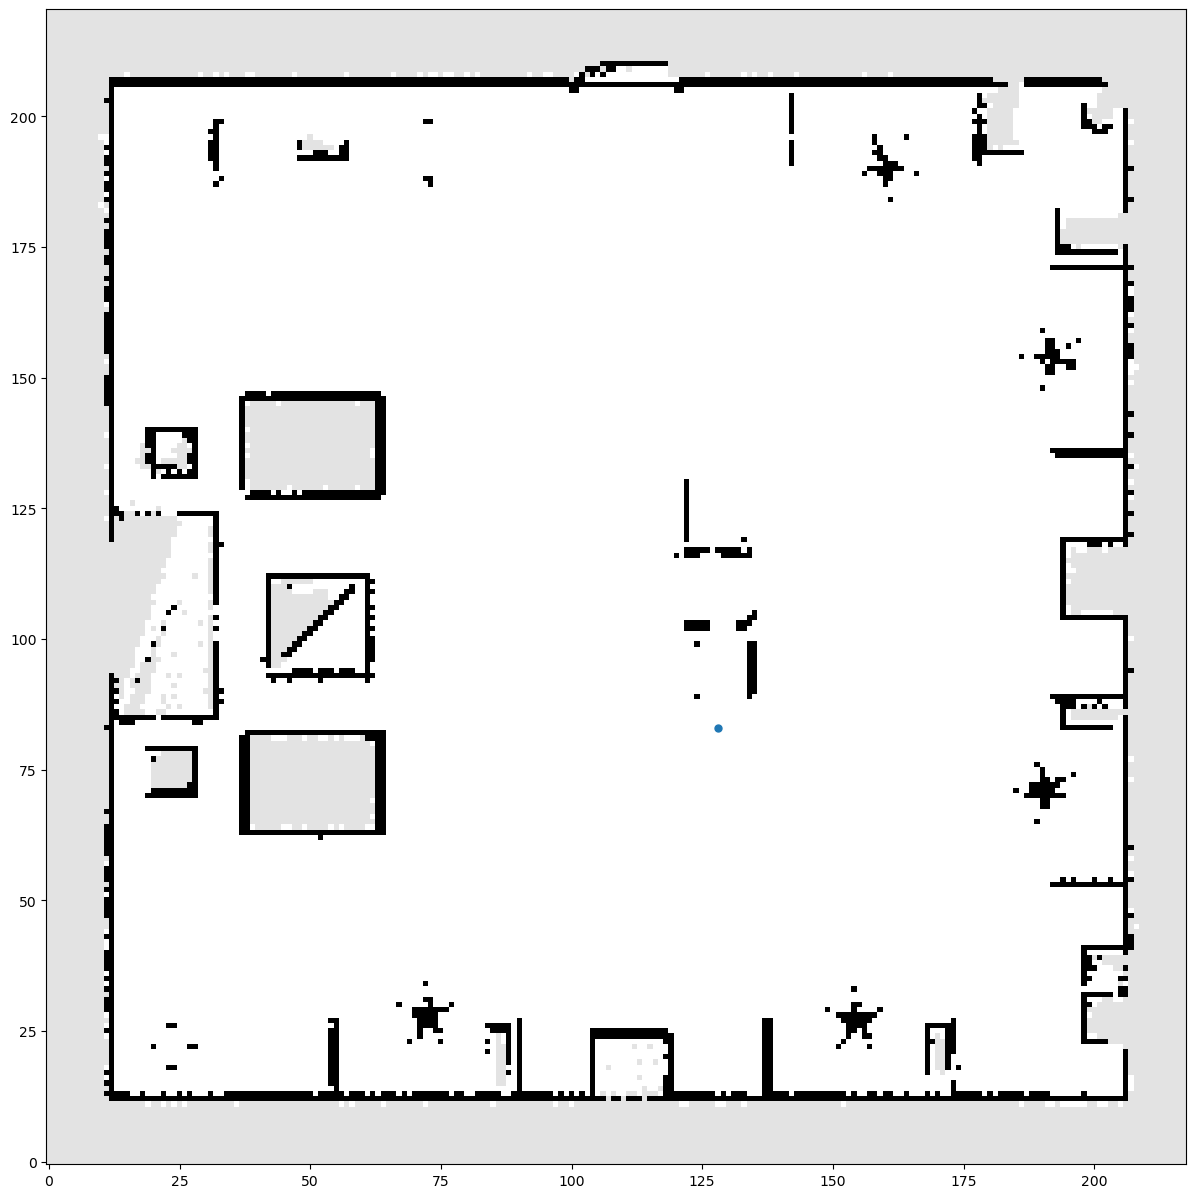

In [109]:
plt.figure(figsize=(15,15))
gridshow(occ_grid)
plt.scatter(ij_positions[0,0], ij_positions[0,1], s=25, )

### Transform from camera frame to map frame (single image)

In [110]:
# camera intrinsic
K = K.reshape(3,3)
K_inv = np.linalg.inv(K)

#segmented image
img = Image.imread("../Results/RGBD/segment/8603.168000.jpg")
depth = Image.imread("../Results/RGBD/depth/8603.168000.png")

print(img[479,639,:])

[255 120  70]


/tmp/ipykernel_10174/2300399959.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = Image.imread("../Results/RGBD/segment/8603.168000.jpg")
/tmp/ipykernel_10174/2300399959.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  depth = Image.imread("../Results/RGBD/depth/8603.168000.png")


### 3D points in Camera Frame

In [111]:
pixels = np.zeros((640*480, 3))
z = np.zeros((640*480, 1))
count = 0
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        pixels[count, :] = [i,j,1]
        z[count,:] = depth[j,i]/1000
        count +=1

#### transform from pixel to camera frame

In [113]:
camera_frame = (np.matmul(K_inv, pixels.T)).T
print(camera_frame)

[[-0.57812048 -0.43381584  1.        ]
 [-0.57812048 -0.43201203  1.        ]
 [-0.57812048 -0.43020822  1.        ]
 ...
 [ 0.57451286  0.4266006   1.        ]
 [ 0.57451286  0.42840441  1.        ]
 [ 0.57451286  0.43020822  1.        ]]


In [114]:
camera_frame = camera_frame * z
print(camera_frame)

[[-1.75517378 -1.31706488  3.036     ]
 [-1.75690814 -1.31288455  3.039     ]
 [-1.75690814 -1.30740278  3.039     ]
 ...
 [ 0.2947251   0.21884611  0.513     ]
 [ 0.29357607  0.21891465  0.511     ]
 [ 0.29242705  0.21897598  0.509     ]]


### Tranform from camera frame to map frame

In [127]:
def homogenous(roll, pitch, yaw, translation):
    cos_r = np.cos(roll)
    sin_r = np.sin(roll)
    cos_p = np.cos(pitch)
    sin_p = np.sin(pitch)
    cos_y = np.cos(yaw)
    sin_y = np.sin(yaw) 

    # print(translation.shape)
    rotation = np.array([[cos_p*cos_y, -cos_r*sin_y + sin_r*sin_p*cos_y, sin_r*sin_y + cos_r*sin_p*cos_y],
                        [cos_p*sin_y, cos_r*cos_y + sin_r*sin_p*sin_y, -sin_r*cos_y + cos_r*sin_p*sin_y],
                        [-sin_p, sin_r*cos_p, cos_r*cos_p]])


    homogeneous_matrix = np.eye(4)
    homogeneous_matrix[:3, :3] = rotation[:]
    homogeneous_matrix[:3, 3:] = translation.reshape([-1,1])

    return homogeneous_matrix

In [128]:
n_r_t = np.zeros((poses_TF_localization.shape[0], 4, 4))
for i in range(poses_TF_localization.shape[0]):
    tx = poses_TF_localization['X'][i]
    ty = poses_TF_localization['Y'][i]
    tz = poses_TF_localization['Z'][i]
    translation = np.array([[tx, ty, tz]])
    roll = poses_TF_localization['Roll'][i]
    pitch = poses_TF_localization['Pitch'][i]
    yaw = poses_TF_localization['Yaw'][i]
    n_r_t[i] = homogenous(roll, pitch, yaw, translation)


In [130]:
camera_frame_homo = np.ones((camera_frame.shape[0], 4))
camera_frame_homo[:,0:3] = camera_frame[:,:]

In [163]:
H_inv = np.linalg.inv(n_r_t[0])
map_frame = (np.matmul(H_inv, camera_frame_homo.T)).T

In [188]:
map_frame_xy = map_frame[:,[0,1]]
map_frame_xy = map_frame_xy.copy(order='C')
map_frame_ij = map.xy_to_ij(map_frame_xy)

In [168]:
map_frame_ij.shape

(307200, 2)

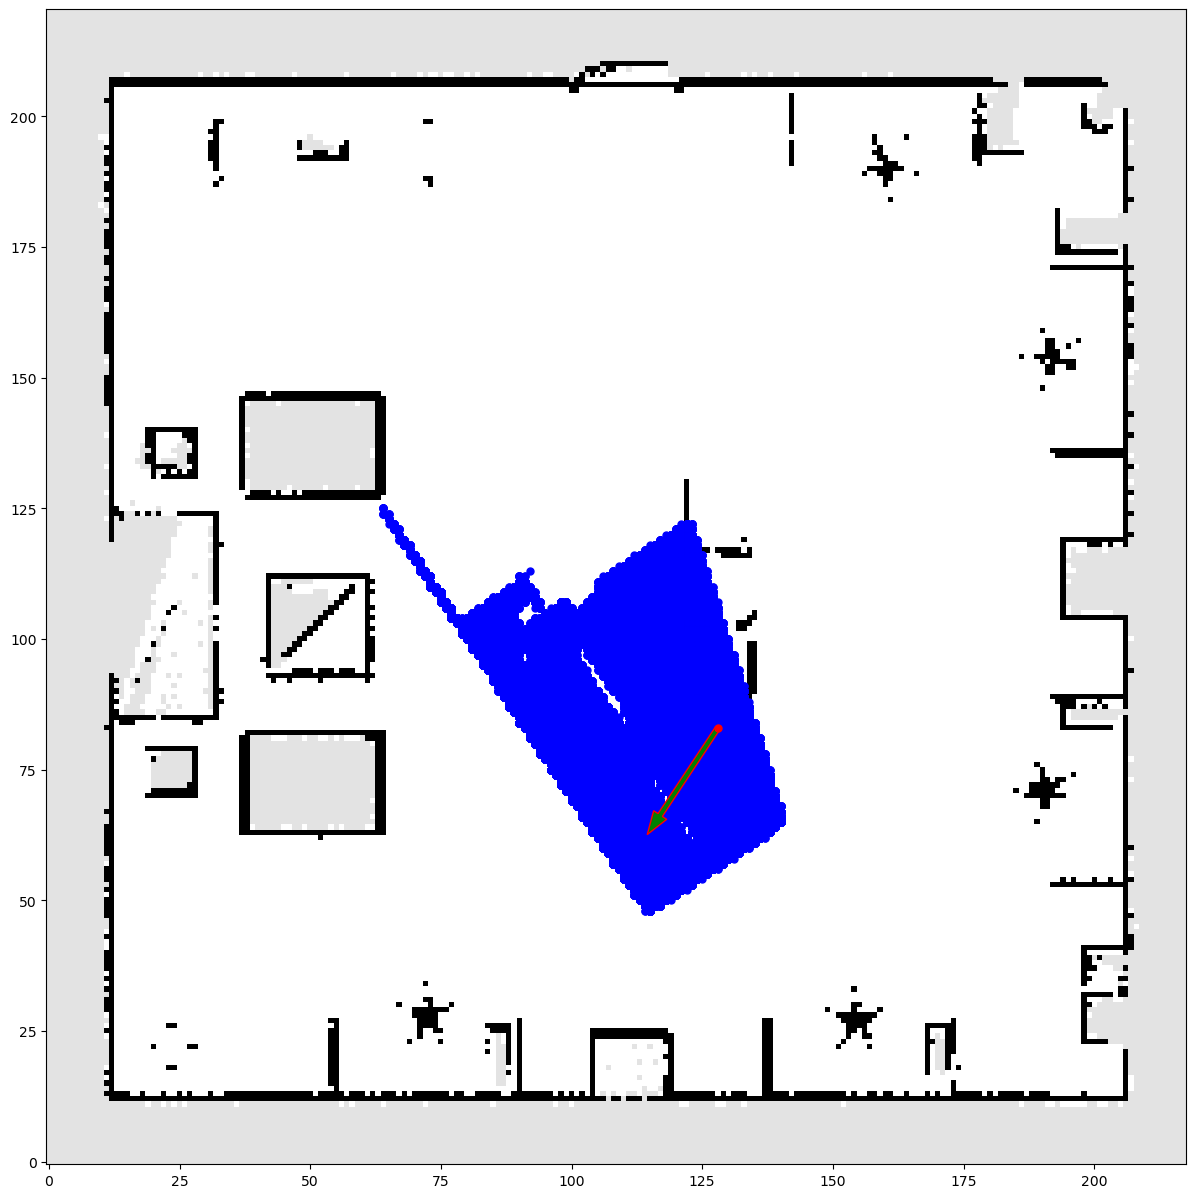

In [189]:
r = 20
plt.figure(figsize=(15,15))
gridshow(occ_grid)

dx = r * np.cos(poses_TF_localization['Yaw'][0])
dy = r * np.sin(poses_TF_localization['Yaw'][0])
x = ij_positions[0,0]
y = ij_positions[0,1]
plt.scatter(map_frame_ij[:,0], map_frame_ij[:, 1], s=25, c= 'b')
plt.arrow(x, y, dx, dy, width=1, ec='r', fc='g')
plt.scatter(ij_positions[0,0], ij_positions[0,1], s=25 , c='r')